In [ ]:
!pip install --upgrade --force-reinstall --no-deps -q albumentations
!pip install --upgrade --force-reinstall --no-deps -q tensorboard
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.1.2.30

!pip install -q pytorch-lightning
!pip install -q torch_tb_profiler
# !pip install -q torchmetrics
!pip install -q torchmetrics==0.7.3
!pip install -q wandb
!pip install qudida

     |████████████████████████████████| 102 kB 20.9 MB/s 
     |████████████████████████████████| 5.8 MB 15.3 MB/s 
     |████████████████████████████████| 21.8 MB 1.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.1.0 requires qudida>=0.0.4, which is not installed.
     |████████████████████████████████| 584 kB 27.1 MB/s 
     |████████████████████████████████| 409 kB 35.0 MB/s 
     |████████████████████████████████| 136 kB 73.0 MB/s 
     |████████████████████████████████| 596 kB 71.3 MB/s 
     |████████████████████████████████| 1.1 MB 47.0 MB/s 
     |████████████████████████████████| 144 kB 69.7 MB/s 
     |████████████████████████████████| 271 kB 64.1 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

Image Prep

In [ ]:
import numpy as np
import os
import glob

from PIL import Image, ImageOps
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import shutil
from typing import Optional, Tuple, List

import albumentations as A
import pytorch_lightning as pl
import torch as pt
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchmetrics import MetricCollection, Accuracy, F1, IoU, Precision, Recall

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import wandb
import pandas as pd

In [ ]:
def make_dir(output_path):
  if not os.path.isdir(output_path):
    os.mkdir(output_path)

Model Def

In [ ]:
class IceTilesDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.img_list = glob.glob(f'{dataset_dir}/image/*')
        self.img_list.sort()
        self.msk_list = glob.glob(f'{dataset_dir}/mask/*')
        self.msk_list.sort()
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(self.img_list[index]).convert('RGB')
        msk = Image.open(self.msk_list[index]).convert('L')
        img = np.array(img)
        msk = np.array(msk)
        if self.transform is not None:
            transformed = self.transform(image=img, mask=msk)
            img = transformed["image"]
            msk = transformed["mask"]
        msk = msk.long()
        return {'image': img, 'mask': msk}

    def __len__(self):
        return len(self.img_list)

In [ ]:
common_transforms = [
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]

NUM_WORKERS = os.cpu_count()


class IceTilesDataModule(pl.LightningDataModule):
    def __init__(
            self,
            tmp_dir: str = './tmp_ice_data',
            dataset_name: Optional[str] = None,
            tile_shape: Optional[Tuple[int, int]] = (256, 256),
            batch_size: int = 16
    ):
        super().__init__()
        self.dataset_name = dataset_name
        self.tmp_dir = tmp_dir
        self.tile_shape = tile_shape
        self.batch_size = batch_size
        self.cloud_dataset = dataset_name is not None
        self.output_dir = tmp_dir if not self.cloud_dataset else None

    def setup(self, stage: Optional[str] = None):
        if self.cloud_dataset:
            make_dir(self.tmp_dir)
            self.__fetch_tiles()

    def __fetch_tiles(self):
        dataset_dir_root = f'{self.tmp_dir}/{self.dataset_name}'
        make_dir(dataset_dir_root)
        artifact = wandb.use_artifact(f'{self.dataset_name}:latest')
        artifact_dir = artifact.download(root=dataset_dir_root)
        self.output_dir = f'{artifact_dir}/{self.tile_shape[0]}x{self.tile_shape[1]}'

    def __create_dataloader(self, dataset):
        return DataLoader(dataset, batch_size=self.batch_size, num_workers=NUM_WORKERS, pin_memory=True)

    def train_dataloader(self):
        train_transforms = A.Compose(
            [
                A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                *common_transforms
            ]
        )
        train_dataset = IceTilesDataset(f'{self.output_dir}/train', train_transforms)
        return self.__create_dataloader(train_dataset)

    def val_dataloader(self):
        val_transforms = A.Compose([
            *common_transforms
        ])
        val_dataset = IceTilesDataset(f'{self.output_dir}/val', val_transforms)
        return self.__create_dataloader(val_dataset)

    def test_dataloader(self):
        test_transforms = A.Compose([
            *common_transforms
        ])
        test_dataset = IceTilesDataset(f'{self.output_dir}/test', test_transforms)
        return self.__create_dataloader(test_dataset)

    def teardown(self, stage=None):
        if self.cloud_dataset:
            shutil.rmtree(f'{self.tmp_dir}/{self.dataset_name}', ignore_errors=True)
            shutil.rmtree(self.output_dir, ignore_errors=True)

In [ ]:
backbone_dict = {
    'fcn_resnet50': models.segmentation.fcn_resnet50,
    'fcn_resnet101': models.segmentation.fcn_resnet101,
    'deeplabv3_resnet50': models.segmentation.deeplabv3_resnet50,
    'deeplabv3_resnet101': models.segmentation.deeplabv3_resnet101,
    'deeplabv3_mobilenet_v3_large': models.segmentation.deeplabv3_mobilenet_v3_large,
    'lraspp_mobilenet_v3_large': models.segmentation.lraspp_mobilenet_v3_large,
}


def fetch_backbone_model(model_name, num_classes):
    model = backbone_dict[model_name]
    return model(
        pretrained=False,
        progress=True,
        num_classes=num_classes
    )


In [ ]:
optimizer_dict = {
    'SGD': pt.optim.SGD,
    'Adam': pt.optim.Adam,
    'AdamW': pt.optim.AdamW
}


class IceClassifierSystem(pl.LightningModule):
    def __init__(
            self,
            num_classes: int,
            backbone_model: str,
            optimizer: str,
            learning_rate: float,
            loss_weights: List[float]
    ):
        super(IceClassifierSystem, self).__init__()
        self.save_hyperparameters()

        self.backbone = fetch_backbone_model(backbone_model, num_classes=num_classes)
        self.softmax = pt.nn.LogSoftmax(dim=1)
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.__configure_metrics(num_classes)
        self.loss_weights = pt.FloatTensor(loss_weights)

    def __configure_metrics(self, num_classes):
        metrics_config = {
            "num_classes": num_classes,
            "mdmc_average": 'global'
        }
        self.train_metrics = [
            MetricCollection(
                [
                    Accuracy(**metrics_config, average=average),
                    F1(**metrics_config, average=average),
                ],
                prefix='train/',
                postfix=f'_{average}'
            )
            for average in ['micro', 'macro']
        ]
        self.val_metrics = [
            MetricCollection(
                [
                    Accuracy(**metrics_config, average=average),
                    Precision(**metrics_config, average=average),
                    Recall(**metrics_config, average=average),
                    F1(**metrics_config, average=average),
                ],
                prefix='val/',
                postfix=f'_{average}'
            )
            for average in ['micro', 'macro']
        ]
        self.val_metrics.append(
            MetricCollection(
                [
                    IoU(num_classes=num_classes)
                ],
                prefix='val/'
            )
        )
        self.test_metrics = [mc.clone(prefix='test/') for mc in self.val_metrics]

    def add_model_specific_args(parent_parser):
        parser = parent_parser.add_argument_group("IceClassifierSystem")
        parser.add_argument('--batch_size', type=int, default=16)
        parser.add_argument('--backbone_model', type=str, default='deeplabv3_resnet101')
        parser.add_argument('--dataset', type=str, default='original')
        parser.add_argument('--local_mode', type=bool, default=False)
        parser.add_argument('--dataset_path', type=str,
                            default='./resources/datasets/ice-tiles-dataset-goodlight-only-revised/256x256')
        parser.add_argument('--optimizer', type=str, default='AdamW')
        parser.add_argument('--learning_rate', type=float, default=5e-5)
        return parent_parser

    def forward(self, batch):
        outputs = self.backbone(batch['image'])
        logits = outputs['out']
        probs = self.softmax(logits)
        return probs

    def training_step(self, batch, batch_idx):
        labels = batch['mask']
        logits = self(batch)
        loss_weights = self.loss_weights.to(device=self.device)
        batch_loss = F.nll_loss(logits, labels, weight=loss_weights)

        self.log('train/loss', batch_loss, sync_dist=True)
        return {'loss': batch_loss, 'preds': logits.detach(), 'target': labels.detach()}

    def training_step_end(self, outputs):
        for train_metrics in self.train_metrics:
            train_metrics = train_metrics.to(self.device)
            metrics = train_metrics(outputs['preds'], outputs['target'])
            self.log_dict(metrics, sync_dist=True)

    def validation_step(self, batch, batch_idx):
        labels = batch['mask']
        logits = self(batch)
        loss_weights = self.loss_weights.to(device=self.device)
        batch_loss = F.nll_loss(logits, labels, weight=loss_weights)

        self.log('val/loss', batch_loss, sync_dist=True)
        return {'loss': batch_loss, 'preds': logits.detach(), 'target': labels.detach()}

    def validation_step_end(self, outputs):
        for val_metrics in self.val_metrics:
            val_metrics = val_metrics.to(self.device)
            metrics = val_metrics(outputs['preds'], outputs['target'])
            self.log_dict(metrics, sync_dist=True)

    def test_step(self, batch, batch_idx):
        labels = batch['mask']
        logits = self(batch)
        loss_weights = self.loss_weights.to(device=self.device)
        batch_loss = F.nll_loss(logits, labels, weight=loss_weights)

        self.log('test/loss', batch_loss, sync_dist=True)
        return {'loss': batch_loss, 'preds': logits.detach(), 'target': labels.detach()}

    def test_step_end(self, outputs):
        for test_metrics in self.test_metrics:
            test_metrics = test_metrics.to(self.device)
            metrics = test_metrics(outputs['preds'], outputs['target'])
            self.log_dict(metrics, sync_dist=True)

    def configure_optimizers(self):
        optimizer_class = optimizer_dict[self.optimizer]
        optimizer = optimizer_class(self.parameters(), lr=self.learning_rate)
        return optimizer

Eval

In [ ]:
CLASS_COUNT = 6
LEARNING_RATE = 4.034922822211346e-05
EPOCH_COUNT = 32
BATCH_SIZE = 80

In [ ]:
WANDB_PROJECT = 'IceClassificationGoodlightOnlyRevised'
WANDB_ENTITY = 'semanticsegmentation'

wandb.init(
  job_type='model-eval',
  project=WANDB_PROJECT,
  entity=WANDB_ENTITY,
  settings=wandb.Settings(start_method="thread")
)

# model-ijvzh6hv:v29 morning-sweep-50, BadlightCLAHE
# model-ftjhl6wc:v27

# model-x8duelh5:v30 solar-sweep-56, GoodlightOnly

# model-tdrkmeoy:v27
# model-z2khudy9:v20
# model-2f0y8kzw:v27

artifact = wandb.use_artifact('semanticsegmentation/IceClassificationGoodlightOnlyRevised/model-x96mrraw:v13', type='model',)
artifact_dir = artifact.download()

wandb: Downloading large artifact model-x96mrraw:v13, 595.22MB. 1 files... Done. 0:0:0


In [ ]:
MODEL_DIR_PATH = artifact_dir
MODEL_NAME = '/model.ckpt'
MODEL_PATH = MODEL_DIR_PATH + MODEL_NAME

model = IceClassifierSystem.load_from_checkpoint(
  MODEL_PATH,
  num_labels=CLASS_COUNT,
  learning_rate=LEARNING_RATE
)

In [ ]:
DATASET_NAME = 'ice-tiles-dataset-goodlight-only-revised'
TMP_DIR = f'/tmp/'
TILE_SHAPE = (256, 256)

data_module = IceTilesDataModule(
  tmp_dir=TMP_DIR,
  dataset_name=DATASET_NAME,
  tile_shape=TILE_SHAPE,
  batch_size=BATCH_SIZE
)
data_module.setup()

wandb: Downloading large artifact ice-tiles-dataset-goodlight-only-revised:latest, 1228.23MB. 9816 files... Done. 0:0:0


In [ ]:
class EvalSegDataset(pt.utils.data.Dataset):
  def __init__(self, input_dir, img_list, transform=None):
    self.input_dir = input_dir
    self.img_list = img_list
    self.transform = transform

  def __getitem__(self, index):
    img = Image.open(f'{self.input_dir}/{self.img_list[index]}.tif').convert('RGB')
    img = np.array(img)
    if self.transform is not None:
      transformed = self.transform(image=img)
      img = transformed["image"]
    return {'image': img}

  def __len__(self):
    return len(self.img_list)

In [ ]:
def get_predictions(trainer, model, data_loader):
  logits = trainer.predict(model, data_loader)
  logits = [batch.cpu().detach().numpy() for batch in logits]
  logits = np.vstack(logits)
  preds = np.argmax(logits, axis=1)
  return preds

In [ ]:
transform_val = A.Compose(
  [
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
  ]
)

def predict_tiles(input_dir, img_list):
  dataset_pred = EvalSegDataset(input_dir, img_list, transform_val)
  loader_pred = DataLoader(dataset_pred, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
  trainer = pl.Trainer(gpus=1, deterministic=True)
  return get_predictions(trainer, model, loader_pred)

In [ ]:
class EvalImageMerger:
  def __init__(self, input_dir):
    file_paths = glob.glob(f'{input_dir}/*')
    img_df = self.__process_filepaths(file_paths)
    self.input_dir = input_dir
    self.img_df_list = [e[1] for e in list(img_df.groupby(['img_index']))]

  def __process_filepaths(self, file_paths):
    parts_list = [self.__process_filepath(file_path) for file_path in file_paths]
    return pd.DataFrame(parts_list, columns=['rootname', 'img_index', 'x_index', 'y_index'])

  def __process_filepath(self, filepath):
    basename = os.path.basename(filepath)
    root = os.path.splitext(basename)[0]
    indexes = [int(index) for index in root.split("_")]
    return [root] + indexes

  def transform(self, predict_fn, tile_shape, output_directory):
    for img_df in tqdm(self.img_df_list):
      self.__process_image(img_df, tile_shape, output_directory)
      self.__process_pred(img_df, predict_fn, tile_shape, output_directory)

  def __process_image(self, img_df, tile_shape, output_directory):
    img_df = img_df.sort_values(by=['x_index', 'y_index'])
    img_index = img_df['img_index'].iloc[0]
    grid_shape = self.__get_grid_shape(img_df)

    img = EvalSegDataset(self.input_dir, list(img_df['rootname']))
    img = self.__process_tile(img, grid_shape, tile_shape)
    self.__save_image(img, output_directory, img_index, 'img')

  def __process_tile(self, img_list, grid_shape, tile_shape):
    grid_size = self.__get_grid_size(grid_shape, tile_shape)
    img_arr = np.zeros(shape=(grid_size[1], grid_size[0], 3))
    for x_index in range(grid_shape[0]):
      for y_index in range(grid_shape[1]):
        grid_coords = (x_index, y_index)
        x = x_index * tile_shape[0]
        y = y_index * tile_shape[1]
        df_index = grid_coords[0] * grid_shape[1] + grid_coords[1]
        img_arr[y:y+tile_shape[1],x:x+tile_shape[0]] = img_list[df_index]['image']
    return img_arr

  def __process_pred(self, img_df, predict_fn, tile_shape, output_directory):
    img_df = img_df.sort_values(by=['x_index', 'y_index'])
    img_index = img_df['img_index'].iloc[0]
    grid_shape = self.__get_grid_shape(img_df)

    prd = predict_fn(self.input_dir, list(img_df['rootname']))
    prd = self.__process_part(prd, grid_shape, tile_shape)
    self.__save_image(prd, output_directory, img_index, 'prd')

  def __process_part(self, img_list, grid_shape, tile_shape):
    grid_size = self.__get_grid_size(grid_shape, tile_shape)
    img_arr = np.zeros(shape=(grid_size[1], grid_size[0]))
    for x_index in range(grid_shape[0]):
      for y_index in range(grid_shape[1]):
        grid_coords = (x_index, y_index)
        x = x_index * tile_shape[0]
        y = y_index * tile_shape[1]
        df_index = grid_coords[0] * grid_shape[1] + grid_coords[1]
        img_arr[y:y+tile_shape[1],x:x+tile_shape[0]] = img_list[df_index]
    return img_arr

  def __get_grid_shape(self, img_df):
    x_count = img_df['x_index'].max() + 1
    y_count = img_df['y_index'].max() + 1
    return (x_count, y_count)

  def __get_grid_size(self, grid_shape, tile_shape):
    x_size = (grid_shape[0] + 1) * tile_shape[0]
    y_size = (grid_shape[1] + 1) * tile_shape[1]
    return (x_size, y_size)

  def __save_image(self, img_arr, output_directory, img_index, img_suffix):
    img = Image.fromarray(img_arr.astype(np.uint8))
    img.save(f'{output_directory}/{img_index:02d}_{img_suffix}.tif')

In [ ]:
DATASET_DIR = '/tmp/ice-tiles-dataset-goodlight-only-revised/256x256/train/image'
OUTPUT_DIR = '/tmp/ice-tiles-dataset-goodlight-only-revised-output'

image_merger = EvalImageMerger(DATASET_DIR)
make_dir(OUTPUT_DIR)
image_merger.transform(predict_tiles, tile_shape=(256,256), output_directory=OUTPUT_DIR)

  0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
def show_prediction(file_path):
  cmap = ListedColormap(["white","#bedbe2","#c0c6c7","#3281bc", "#08306b"], name='from_list', N=None)
  plt.figure(figsize=(8, 6), dpi=80)

  img = Image.open(f'{file_path}_img.tif').convert('RGB')
  img = np.array(img)
  ax = plt.subplot(1, 2, 1)
  ax.imshow(img)
  ax.set_title('image')
  
  prd = Image.open(f'{file_path}_prd.tif').convert('L')
  prd = np.array(prd)
  ax = plt.subplot(1, 2, 2)
  ax.imshow(prd, cmap=cmap)
  ax.set_title('prediction')

  plt.tight_layout()

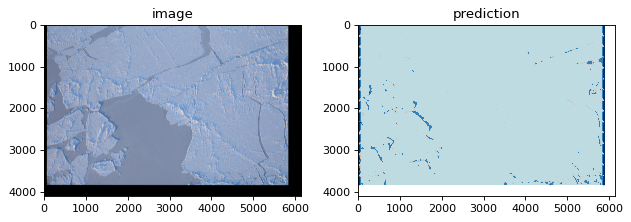

In [ ]:
show_prediction(f'{OUTPUT_DIR}/00')

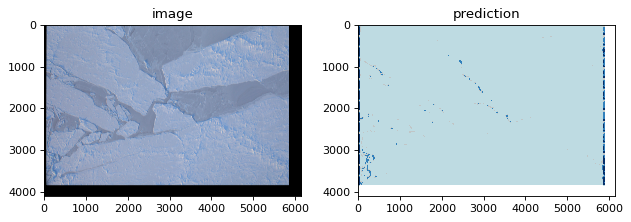

In [ ]:
show_prediction(f'{OUTPUT_DIR}/01')

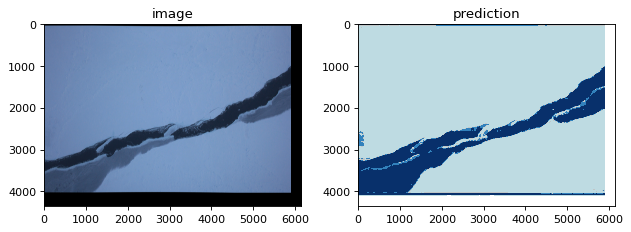

In [ ]:
show_prediction(f'{OUTPUT_DIR}/02')

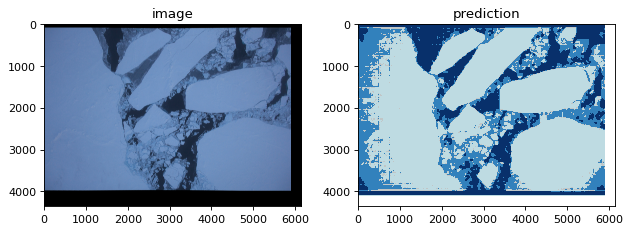

In [ ]:
show_prediction(f'{OUTPUT_DIR}/03')

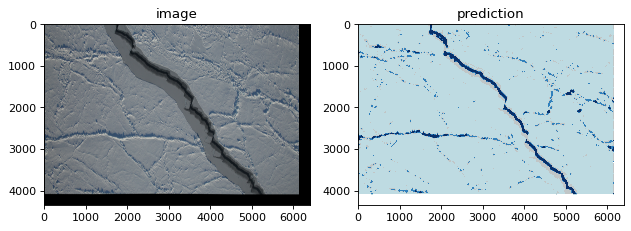

In [ ]:
show_prediction(f'{OUTPUT_DIR}/04')

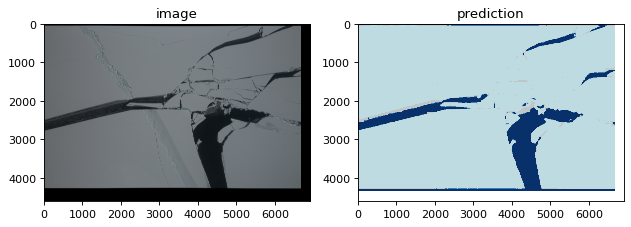

In [ ]:
show_prediction(f'{OUTPUT_DIR}/05')

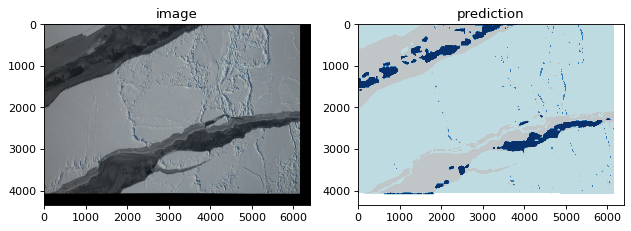

In [ ]:
show_prediction(f'{OUTPUT_DIR}/06')

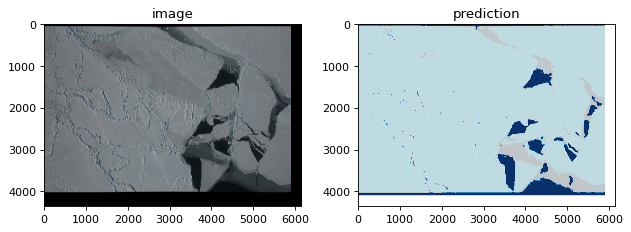

In [ ]:
show_prediction(f'{OUTPUT_DIR}/07')

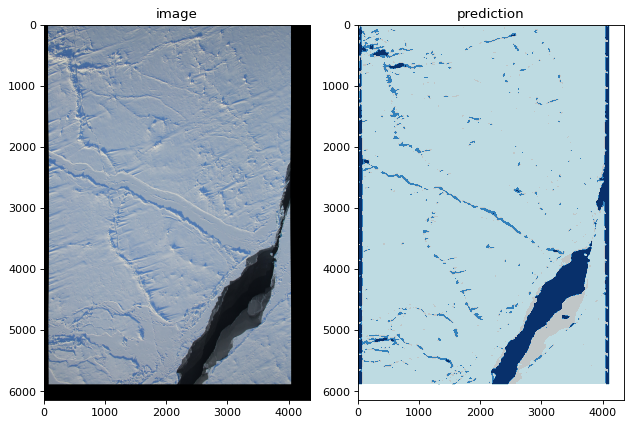

In [ ]:
show_prediction(f'{OUTPUT_DIR}/08')

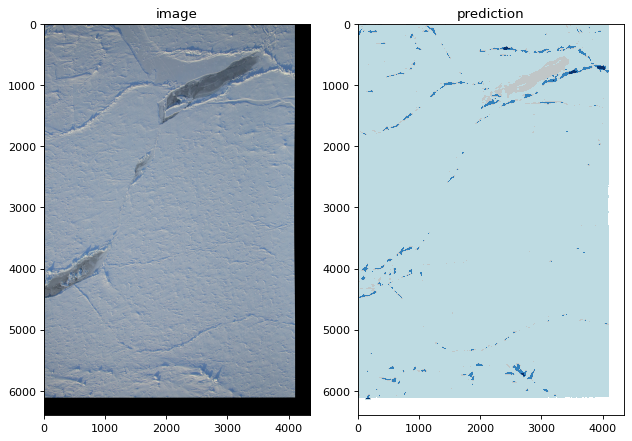

In [ ]:
show_prediction(f'{OUTPUT_DIR}/09')

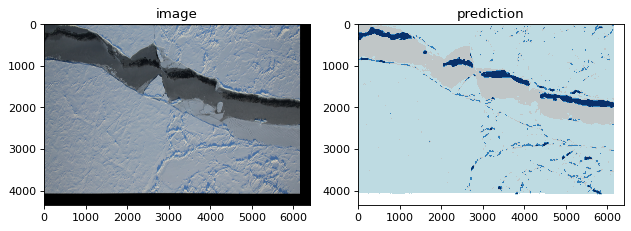

In [ ]:
show_prediction(f'{OUTPUT_DIR}/10')

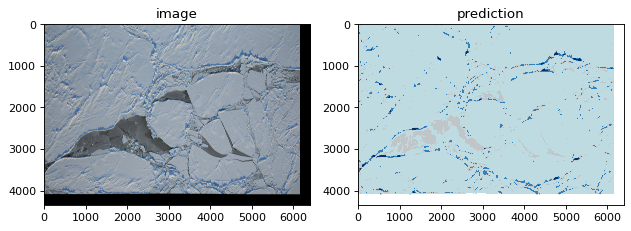

In [ ]:
show_prediction(f'{OUTPUT_DIR}/11')

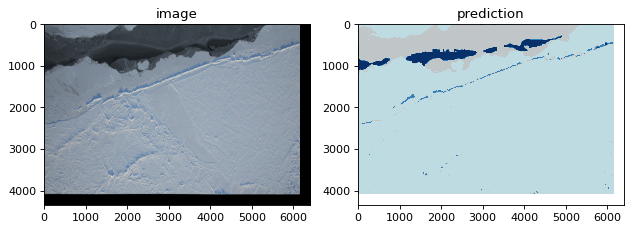

In [ ]:
show_prediction(f'{OUTPUT_DIR}/12')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/13')

FileNotFoundError: ignored

<Figure size 640x480 with 0 Axes>

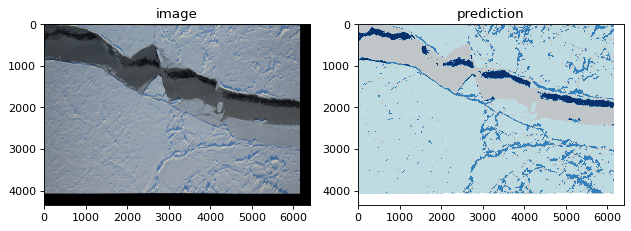

In [ ]:
show_prediction(f'{OUTPUT_DIR}/14')

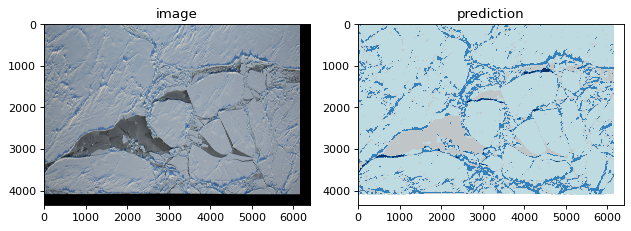

In [ ]:
show_prediction(f'{OUTPUT_DIR}/15')

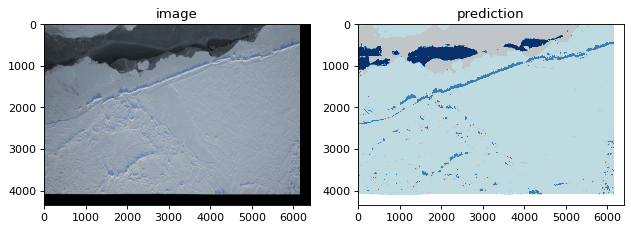

In [ ]:
show_prediction(f'{OUTPUT_DIR}/16')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/17')

FileNotFoundError: ignored

<Figure size 640x480 with 0 Axes>

In [ ]:
show_prediction(f'{OUTPUT_DIR}/18')

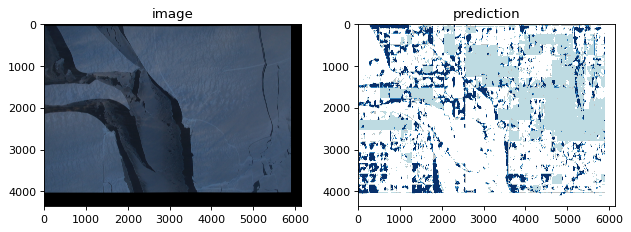

In [ ]:
show_prediction(f'{OUTPUT_DIR}/19')

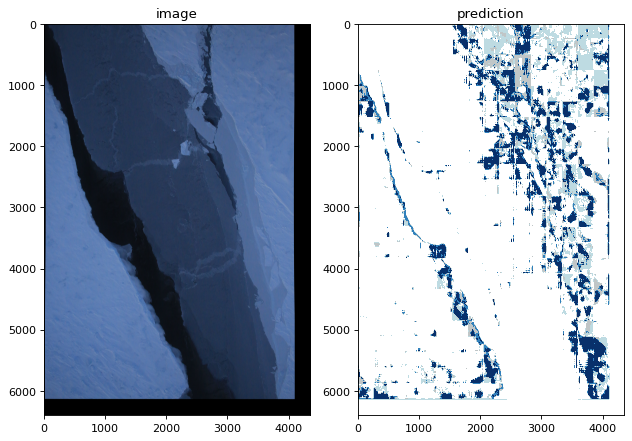

In [ ]:
show_prediction(f'{OUTPUT_DIR}/20')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/21')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/22')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/23')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/24')

FileNotFoundError: ignored

<Figure size 640x480 with 0 Axes>

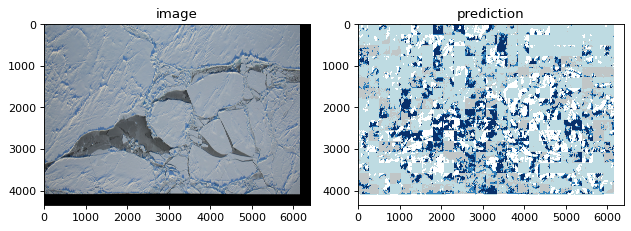

In [ ]:
show_prediction(f'{OUTPUT_DIR}/25')